In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Epoch 1/50
 - 8s - loss: 3.4019 - acc: 0.0449 - val_loss: 3.3988 - val_acc: 0.0490
Epoch 2/50
 - 6s - loss: 3.3828 - acc: 0.0552 - val_loss: 3.4038 - val_acc: 0.0620
Epoch 3/50
 - 6s - loss: 3.3796 - acc: 0.0568 - val_loss: 3.3982 - val_acc: 0.0620
Epoch 4/50
 - 6s - loss: 3.3791 - acc: 0.0554 - val_loss: 3.4026 - val_acc: 0.0620
Epoch 5/50
 - 6s - loss: 3.3790 - acc: 0.0548 - val_loss: 3.4076 - val_acc: 0.0620

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
 - 6s - loss: 3.3778 - acc: 0.0575 - val_loss: 3.3964 - val_acc: 0.0620
Epoch 7/50
 - 6s - loss: 3.3772 - acc: 0.0566 - val_loss: 3.3978 - val_acc: 0.0620
Epoch 8/50
 - 6s - loss: 3.3786 - acc: 0.0568 - val_loss: 3.3958 - val_acc: 0.0620

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/50
 - 6s - loss: 3.3757 - acc: 0.0566 - val_loss: 3.3931 - val_acc: 0.0620
Epoch 10/50
 - 6s - loss: 3.3776 - acc: 0.0549 - val_loss: 3.3941 - val_acc: 0.0620
Epoch 1

C:\Users\Eric Vuong\Anaconda3\envs\tensorflowgpu\lib\site-packages\matplotlib\axes\_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


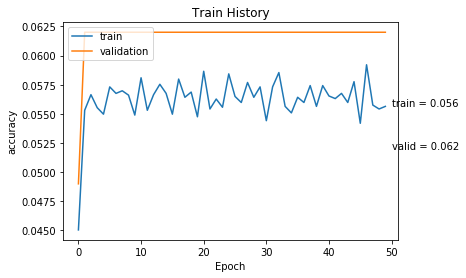

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import math

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2 as cv
from PIL import Image

import multiprocessing
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2

def preProcessImageObsolete(image, cutoff=127, maxContours=5):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.uint8(np.ones(im.shape))
    largest_contours = sorted(contours, key=cv2.contourArea)
    for ind, contour in enumerate(largest_contours[maxContours:]):
        mask = cv2.drawContours(mask, [largest_contours[ind]], -1, 0, -1)
        
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    ## plt.imshow(filteredImage)
    return filteredImage

def preprocess(image, cutoff=127, maxContours=5):
    image = np.uint8(image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image,connectivity = 4)
    sizes = stats[:,-1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2,nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img = np.zeros(output.shape)
    img[output == max_label] = 255
    return img

def preProcessImage(image, cutoff=127, maxContours=10):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for ind, contour in enumerate(largest_contours[:5]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255    
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    #plt.imshow(filteredImage)
    #plt.figure()
    #plt.imshow(thresh)
    #plt.figure()
    #plt.imshow(mask)
    return filteredImage.reshape((image.shape))

data = np.load("all/train_images.npy",encoding='bytes')

x = []
for image in data:
    image = image[1].reshape(100,100)
   # image = preprocess(image)
    x.append(image)

x_pre = []
for image in data:
    image = image[1].reshape(100,100)
    x_pre.append(image)



labels = pd.read_csv("all/train_labels.csv")
y = []
for i in range(len(labels)):
    label = labels['Category'][i]
    y.append(label)


x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.1, random_state=30)

x_train_backup = x_train
x_validation_backup = x_validation

x_train = np.array(x_train).reshape(len(x_train), 100, 100, 1).astype('float32') / 255
x_validation = np.array(x_validation).reshape(len(x_validation), 100, 100, 1).astype('float32') / 255

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.fit_transform(y_validation)

y_train_decoded = encoder.inverse_transform(y_train)
y_validation_decoded = encoder.inverse_transform(y_train)


##Setup CNN
model = Sequential()
model.add(Conv2D(filters=20,
                 kernel_size=(3, 3),
                 padding='same',
                 input_shape=(100, 100, 1),
                 activation='relu'))
model.add(Conv2D(filters=20,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(Conv2D(filters=80,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(31, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

##Fit CNN model
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images
datagen.fit(x_train)




learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)




batch_size = 32
epochs = 50
train_history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs, validation_data=(x_validation, y_validation),
                                    verbose=2, steps_per_epoch=x_train.shape[0] // batch_size
                                    , callbacks=[learning_rate_reduction])


plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
epoch_num = len(train_history.epoch)
final_epoch_train_acc = train_history.history['acc'][epoch_num - 1]
final_epoch_validation_acc = train_history.history['val_acc'][epoch_num - 1]
plt.text(epoch_num, final_epoch_train_acc, 'train = {:.3f}'.format(final_epoch_train_acc))
plt.text(epoch_num, final_epoch_validation_acc-0.01, 'valid = {:.3f}'.format(final_epoch_validation_acc))
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.xlim(xmax=epoch_num+1)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


data_test = np.load("all/test_images.npy",encoding='bytes')

x_test = []
for image in data_test:
    image = image[1].reshape(100,100)
    #image = preprocess(image)
    x_test.append(image)

x_test = np.array(x_test).reshape(len(x_test), 100, 100, 1).astype('float32') / 255

prediction = model.predict_classes(x_test)
df = pd.DataFrame(prediction)
df.index += 1
df.index.name = 'Id'
df.columns = ['Category']
df.to_csv('cnn.csv', header=True)

word_class = []
for i in range(len(df)):
    c = encoder.classes_[df['Category'][i+1]]
    word_class.append(c)

word_class = np.array(word_class)
word_class = pd.DataFrame(word_class)
word_class.columns = ['Category']
word_class.to_csv('cnn.csv', header=True)


In [5]:
plt.show()
